In [275]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [276]:
import numpy as np
import re
from numpy import linalg as LA
from time import time
from scipy import sparse
import matplotlib.pyplot as plt

/home/neo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'color'
  
/home/neo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'color'
  if __name__ == '__main__':
/home/neo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'color'
  # Remove the CWD from sys.path while we load stuff.
/home/neo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'color'
  # This is added back by InteractiveShellApp.init_path()
/home/neo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


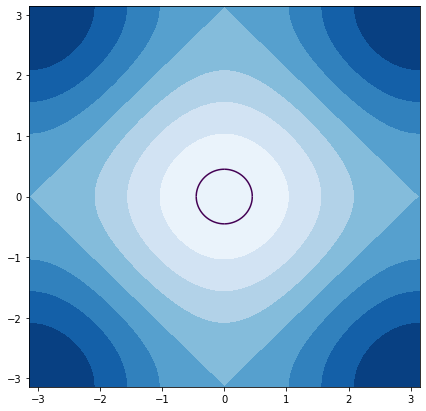

In [277]:
N=100
kx=np.linspace(0,np.pi,N)
ky=np.linspace(0,np.pi,N)
plt.rcParams['figure.figsize'] = [7,7]
Kx,Ky=np.meshgrid(kx,ky)
E=-2*(np.cos(Kx)+np.cos(Ky))
E_F=-3.8
CS=plt.contour(kx,ky,E,levels=[E_F],color='red')
plt.contour(-kx,ky,E,levels=[E_F],color='red')
plt.contour(-kx,-ky,E,levels=[E_F],color='red')
plt.contour(kx,-ky,E,levels=[E_F],color='red')
plt.contourf(kx,ky,E,cmap='Blues')
plt.contourf(-kx,ky,E,cmap='Blues')
plt.contourf(-kx,-ky,E,cmap='Blues')
plt.contourf(kx,-ky,E,cmap='Blues')
F = CS.collections[0].get_paths()[0]
coordsF = F.vertices
vF = np.dstack([2*np.sin(coordsF[:,0]),2*np.sin(coordsF[:,1])])[0]
vFmag = vF[:,0]*vF[:,0]+vF[:,1]*vF[:,1]
shatF  = vF/np.transpose([vFmag])
thetaF0 =  np.float64(np.arctan(vF[:,1]/vF[:,0])) 
coordsFx_irr = coordsF[:,0]
coordsFy_irr = coordsF[:,1]
Lambda0=np.pi/(8*np.sqrt(2))
steps=30000
eps=0.9999
lambdaF=Lambda0*eps**np.linspace(0,steps-1,steps)
ThetaF,LambdaF=np.meshgrid(thetaF0,lambdaF)
Fwvfx_out = coordsFx_irr+LambdaF*np.cos(ThetaF)
Fwvfy_out = coordsFy_irr+LambdaF*np.sin(ThetaF)
EFwvf=-2*(np.cos(Fwvfx_out)+np.cos(Fwvfy_out))

In [278]:
EFwvfAvg=np.sum(EFwvf,axis=1)/len(thetaF0)

In [279]:
J0=1e-2/(N*N)#1.19e9/(N*N)#5e-3/(N*N)
J=np.zeros(steps)
J[0]=J0
omega=4 #1/2 of bandwidth in 2D

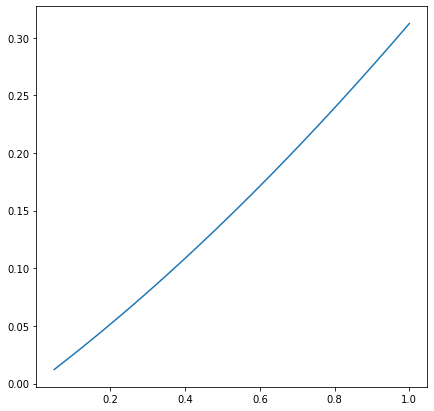

In [280]:
plt.plot(lambdaF/Lambda0,EFwvfAvg-E_F)

In [281]:
k=0
for i in range(len(lambdaF)-1):
    Ek=EFwvfAvg[i]-E_F
    if(Ek-J[0]/4>0):
        if(Ek-J[i]/4>0):

            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            J[i:]=4*Ek
            k=i
            break
    else:
        if(Ek-J[i]/4<0):

            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            J[i:]=4*Ek
            k=i
            break
    

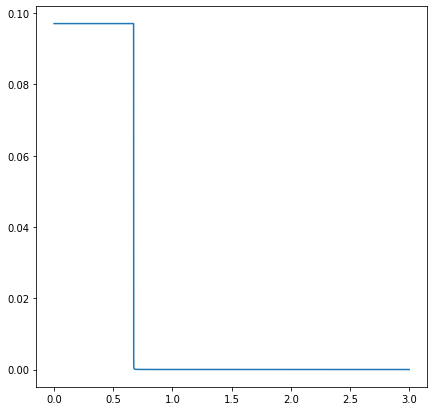

In [282]:
plt.plot(-np.log(lambdaF/Lambda0),J[::-1])

## $Regime-1: J_{0}= 5\times 10^{-3}t$ to $7\times 10^{-3}t$

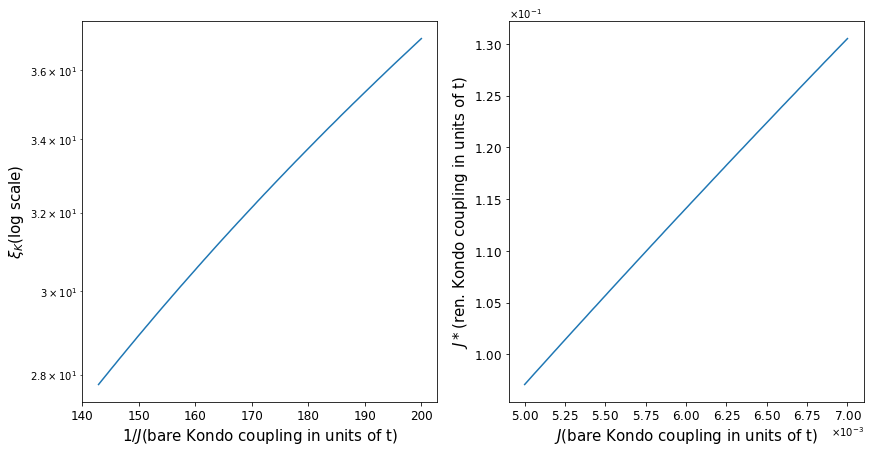

In [341]:
J0arr=np.linspace(5e-3,7e-3,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [14,7]
ax[0].set_yscale('log')
ax[0].plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$1/J$(bare Kondo coupling in units of t)',fontsize=15)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=15)
ax[1].ticklabel_format(style='sci',useMathText=True,scilimits=(1,2))
ax[1].tick_params(labelsize='large')
ax[1].plot(J0arr,JfixedArr,label='URG')
ax[1].set_xlabel(r'$J$(bare Kondo coupling in units of t)',fontsize=15)
ax[1].set_ylabel(r'$J*$(ren. Kondo coupling in units of t)',fontsize=15)
plt.savefig('KondoRegime1.png')

## $Regime-2: J_{0}= 7\times 10^{-3}t$ to $t$

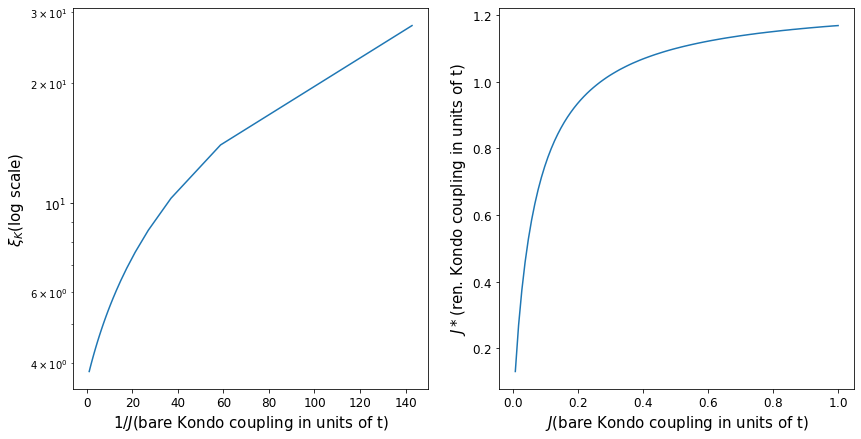

In [340]:
J0arr=np.linspace(7e-3,1,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [14,7]
ax[0].set_yscale('log')
ax[0].plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$1/J$(bare Kondo coupling in units of t)',fontsize=15)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=15)
ax[1].ticklabel_format(style='sci',useMathText=True,scilimits=(1,2))
ax[1].tick_params(labelsize='large')
ax[1].plot(J0arr,JfixedArr,label='URG')
ax[1].set_xlabel(r'$J$(bare Kondo coupling in units of t)',fontsize=15)
ax[1].set_ylabel(r'$J*$(ren. Kondo coupling in units of t)',fontsize=15)
plt.savefig('KondoRegime2.png')

## $Regime-3: J_{0}= t$ to $10t$

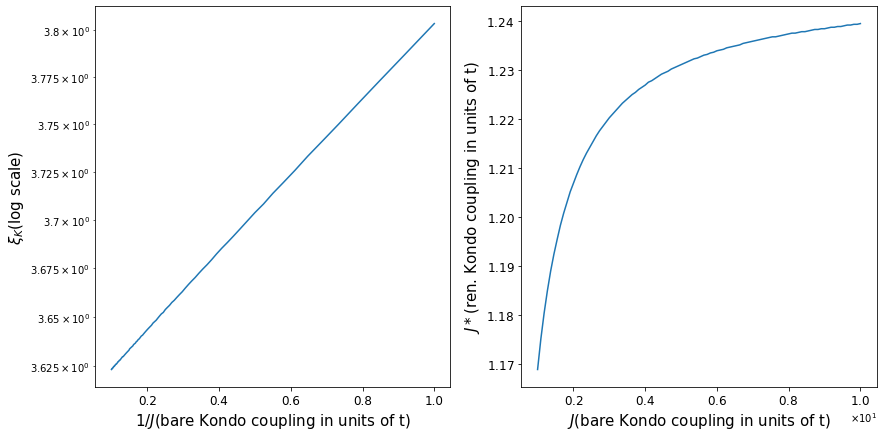

In [355]:
J0arr=np.linspace(1,10,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [14,7]
ax[0].set_yscale('log')
ax[0].plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$1/J$(bare Kondo coupling in units of t)',fontsize=15)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=15)
ax[1].ticklabel_format(style='sci',useMathText=True,scilimits=(1,2))
ax[1].tick_params(labelsize='large')
ax[1].plot(J0arr,JfixedArr,label='URG')
ax[1].set_xlabel(r'$J$(bare Kondo coupling in units of t)',fontsize=15)
ax[1].set_ylabel(r'$J*$(ren. Kondo coupling in units of t)',fontsize=15)
plt.savefig('KondoRegime3.png')

In [125]:
J0arr=np.linspace(9e-3,1,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

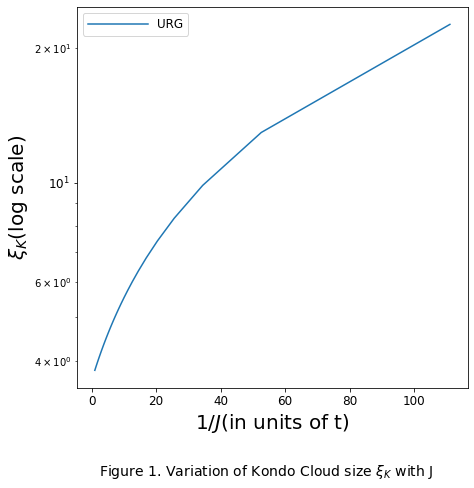

In [126]:
figure,ax=plt.subplots(1)
param=pfit(1/J0arr,np.log(1/(LambdaFParr*Lambda0)),1)
ax.set_yscale('log')
ax.plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax.tick_params(labelsize='large')
ax.set_xlabel(r'$1/J$(in units of t)',fontsize=20)
ax.set_ylabel(r'$\xi_{K}$(log scale)',fontsize=20)
ax.legend(handlelength=5,fontsize=12)
txt=r"Figure 1. Variation of Kondo Cloud size $\xi_{K}$ with J"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.savefig('KondoCloudURG2.png')

In [175]:
J0arr=np.linspace(1,20,2000)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in J0arr:
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0            

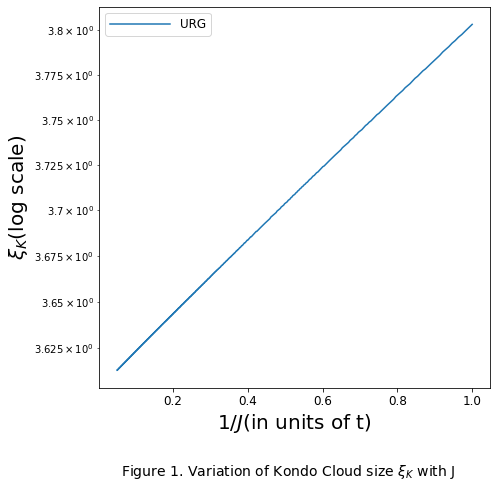

In [177]:
figure,ax=plt.subplots(1)
ax.set_yscale('log')
ax.plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
ax.tick_params(labelsize='large')
ax.set_xlabel(r'$1/J$(in units of t)',fontsize=20)
ax.set_ylabel(r'$\xi_{K}$(log scale)',fontsize=20)
ax.legend(handlelength=5,fontsize=12)
txt=r"Figure 1. Variation of Kondo Cloud size $\xi_{K}$ with J"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.savefig('KondoCloudURG3.png')

In [194]:
from tqdm import tqdm
J0arr=np.linspace(1e4,2e4,100)
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in tqdm(J0arr):
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break  
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0

100%|██████████| 100/100 [00:00<00:00, 24142.66it/s]


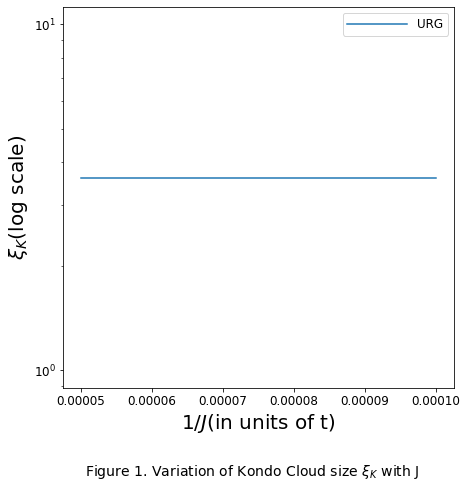

In [195]:
figure,ax=plt.subplots(1)
ax.set_yscale('log')
ax.plot(1/J0arr,(1/(LambdaFParr*Lambda0)),label='URG')
ax.tick_params(labelsize='large')
ax.set_xlabel(r'$1/J$(in units of t)',fontsize=20)
ax.set_ylabel(r'$\xi_{K}$(log scale)',fontsize=20)
ax.legend(handlelength=5,fontsize=12)
txt=r"Figure 1. Variation of Kondo Cloud size $\xi_{K}$ with J"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.savefig('KondoCloudURG4.png')

In [234]:
1.033**1000

125985777245080.69

In [227]:
1e9

1000000000.0

In [268]:
4.9e-3*(1.02656)

0.005030143999999999

In [356]:
#URG
J0arr=4.9e-3*(1.02656)**np.linspace(1,1000,1000)#np.concatenate([np.concatenate([np.linspace(5e-3,1,100),np.linspace(1.1,0.9e8,1000)]),np.linspace(1e8,1.15e9,10000)])
LambdaFParr=0.0*J0arr
JfixedArr=0.0*J0arr
omega=0.0
for J_0 in tqdm(J0arr):
    print(np.where(J0arr==J_0))
    J=np.zeros(steps)
    J[0]=J_0/(N*N)
    k=0
    for i in range(len(lambdaF)-1):
        Ek=EFwvfAvg[i]-E_F
        if(Ek-J[0]/4>0):
            if(Ek-J[i]/4.>0):
                J[i+1]=J[i]+4*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*Ek
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break
        else:
            if(Ek-J[i]/4<0):

                J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
            else:
                JfixedArr[J0arr==J_0]=4*Ek
                k=i
                J[i:]=4*Ek
                break       
            
    LambdaFParr[J0arr==J_0]=lambdaF[k]/Lambda0        

  0%|          | 1/1000 [00:00<01:55,  8.62it/s]

(array([0]),)
(array([1]),)


  0%|          | 3/1000 [00:00<01:50,  9.03it/s]

(array([2]),)
(array([3]),)
(array([4]),)


  1%|          | 7/1000 [00:00<01:43,  9.63it/s]

(array([5]),)
(array([6]),)
(array([7]),)


  1%|          | 9/1000 [00:00<01:46,  9.29it/s]

(array([8]),)
(array([9]),)


  1%|          | 11/1000 [00:01<01:44,  9.43it/s]

(array([10]),)
(array([11]),)
(array([12]),)


  1%|▏         | 14/1000 [00:01<01:45,  9.38it/s]

(array([13]),)
(array([14]),)


  2%|▏         | 18/1000 [00:01<01:36, 10.14it/s]

(array([15]),)
(array([16]),)
(array([17]),)
(array([18]),)


  2%|▏         | 20/1000 [00:01<01:33, 10.52it/s]

(array([19]),)
(array([20]),)
(array([21]),)


  2%|▏         | 24/1000 [00:02<01:28, 10.97it/s]

(array([22]),)
(array([23]),)
(array([24]),)


  3%|▎         | 26/1000 [00:02<01:31, 10.64it/s]

(array([25]),)
(array([26]),)
(array([27]),)


  3%|▎         | 30/1000 [00:02<01:26, 11.23it/s]

(array([28]),)
(array([29]),)
(array([30]),)


  3%|▎         | 32/1000 [00:03<01:22, 11.67it/s]

(array([31]),)
(array([32]),)
(array([33]),)


  4%|▎         | 36/1000 [00:03<01:18, 12.35it/s]

(array([34]),)
(array([35]),)
(array([36]),)
(array([37]),)


  4%|▍         | 40/1000 [00:03<01:14, 12.85it/s]

(array([38]),)
(array([39]),)
(array([40]),)


  4%|▍         | 42/1000 [00:03<01:12, 13.24it/s]

(array([41]),)
(array([42]),)
(array([43]),)


  5%|▍         | 46/1000 [00:04<01:08, 14.00it/s]

(array([44]),)
(array([45]),)
(array([46]),)


  5%|▌         | 50/1000 [00:04<01:05, 14.61it/s]

(array([47]),)
(array([48]),)
(array([49]),)
(array([50]),)


  5%|▌         | 54/1000 [00:04<01:01, 15.38it/s]

(array([51]),)
(array([52]),)
(array([53]),)
(array([54]),)


  6%|▌         | 58/1000 [00:04<00:57, 16.27it/s]

(array([55]),)
(array([56]),)
(array([57]),)
(array([58]),)


  6%|▌         | 62/1000 [00:05<00:55, 17.03it/s]

(array([59]),)
(array([60]),)
(array([61]),)
(array([62]),)


  7%|▋         | 66/1000 [00:05<00:53, 17.51it/s]

(array([63]),)
(array([64]),)
(array([65]),)
(array([66]),)


  7%|▋         | 71/1000 [00:05<00:50, 18.51it/s]

(array([67]),)
(array([68]),)
(array([69]),)
(array([70]),)
(array([71]),)


  8%|▊         | 77/1000 [00:05<00:45, 20.35it/s]

(array([72]),)
(array([73]),)
(array([74]),)
(array([75]),)
(array([76]),)
(array([77]),)


  8%|▊         | 83/1000 [00:05<00:40, 22.81it/s]

(array([78]),)
(array([79]),)
(array([80]),)
(array([81]),)
(array([82]),)
(array([83]),)


  9%|▉         | 89/1000 [00:06<00:36, 24.86it/s]

(array([84]),)
(array([85]),)
(array([86]),)
(array([87]),)
(array([88]),)
(array([89]),)
(array([90]),)


 10%|▉         | 96/1000 [00:06<00:33, 27.02it/s]

(array([91]),)
(array([92]),)
(array([93]),)
(array([94]),)
(array([95]),)
(array([96]),)
(array([97]),)


 10%|█         | 104/1000 [00:06<00:29, 30.84it/s]

(array([98]),)
(array([99]),)
(array([100]),)
(array([101]),)
(array([102]),)
(array([103]),)
(array([104]),)
(array([105]),)
(array([106]),)


 11%|█         | 112/1000 [00:06<00:26, 33.64it/s]

(array([107]),)
(array([108]),)
(array([109]),)
(array([110]),)
(array([111]),)
(array([112]),)
(array([113]),)
(array([114]),)
(array([115]),)


 12%|█▏        | 122/1000 [00:07<00:22, 39.21it/s]

(array([116]),)
(array([117]),)
(array([118]),)
(array([119]),)
(array([120]),)
(array([121]),)
(array([122]),)
(array([123]),)
(array([124]),)
(array([125]),)
(array([126]),)
(array([127]),)


 14%|█▍        | 140/1000 [00:07<00:17, 49.41it/s]

(array([128]),)
(array([129]),)
(array([130]),)
(array([131]),)
(array([132]),)
(array([133]),)
(array([134]),)
(array([135]),)
(array([136]),)
(array([137]),)
(array([138]),)
(array([139]),)
(array([140]),)


 16%|█▌        | 160/1000 [00:07<00:12, 65.97it/s]

(array([141]),)
(array([142]),)
(array([143]),)
(array([144]),)
(array([145]),)
(array([146]),)
(array([147]),)
(array([148]),)
(array([149]),)
(array([150]),)
(array([151]),)
(array([152]),)
(array([153]),)
(array([154]),)
(array([155]),)
(array([156]),)
(array([157]),)
(array([158]),)
(array([159]),)
(array([160]),)
(array([161]),)
(array([162]),)
(array([163]),)
(array([164]),)


 20%|██        | 202/1000 [00:07<00:07, 100.23it/s]

(array([165]),)
(array([166]),)
(array([167]),)
(array([168]),)
(array([169]),)
(array([170]),)
(array([171]),)
(array([172]),)
(array([173]),)
(array([174]),)
(array([175]),)
(array([176]),)
(array([177]),)
(array([178]),)
(array([179]),)
(array([180]),)
(array([181]),)
(array([182]),)
(array([183]),)
(array([184]),)
(array([185]),)
(array([186]),)
(array([187]),)
(array([188]),)
(array([189]),)
(array([190]),)
(array([191]),)
(array([192]),)
(array([193]),)
(array([194]),)
(array([195]),)
(array([196]),)
(array([197]),)
(array([198]),)
(array([199]),)
(array([200]),)
(array([201]),)
(array([202]),)
(array([203]),)
(array([204]),)
(array([205]),)
(array([206]),)
(array([207]),)
(array([208]),)
(array([209]),)
(array([210]),)
(array([211]),)
(array([212]),)
(array([213]),)
(array([214]),)
(array([215]),)
(array([216]),)
(array([217]),)
(array([218]),)
(array([219]),)
(array([220]),)
(array([221]),)
(array([222]),)
(array([223]),)
(array([224]),)
(array([225]),)
(array([226]),)
(array([

 75%|███████▌  | 750/1000 [00:08<00:01, 189.93it/s]

(array([228]),)
(array([229]),)
(array([230]),)
(array([231]),)
(array([232]),)
(array([233]),)
(array([234]),)
(array([235]),)
(array([236]),)
(array([237]),)
(array([238]),)
(array([239]),)
(array([240]),)
(array([241]),)
(array([242]),)
(array([243]),)
(array([244]),)
(array([245]),)
(array([246]),)
(array([247]),)
(array([248]),)
(array([249]),)
(array([250]),)
(array([251]),)
(array([252]),)
(array([253]),)
(array([254]),)
(array([255]),)
(array([256]),)
(array([257]),)
(array([258]),)
(array([259]),)
(array([260]),)
(array([261]),)
(array([262]),)
(array([263]),)
(array([264]),)
(array([265]),)
(array([266]),)
(array([267]),)
(array([268]),)
(array([269]),)
(array([270]),)
(array([271]),)
(array([272]),)
(array([273]),)
(array([274]),)
(array([275]),)
(array([276]),)
(array([277]),)
(array([278]),)
(array([279]),)
(array([280]),)
(array([281]),)
(array([282]),)
(array([283]),)
(array([284]),)
(array([285]),)
(array([286]),)
(array([287]),)
(array([288]),)
(array([289]),)
(array([

 92%|█████████▏| 916/1000 [00:08<00:00, 245.88it/s]

(array([857]),)
(array([858]),)
(array([859]),)
(array([860]),)
(array([861]),)
(array([862]),)
(array([863]),)
(array([864]),)
(array([865]),)
(array([866]),)
(array([867]),)
(array([868]),)
(array([869]),)
(array([870]),)
(array([871]),)
(array([872]),)
(array([873]),)
(array([874]),)
(array([875]),)
(array([876]),)
(array([877]),)
(array([878]),)
(array([879]),)
(array([880]),)
(array([881]),)
(array([882]),)
(array([883]),)
(array([884]),)
(array([885]),)
(array([886]),)
(array([887]),)
(array([888]),)
(array([889]),)
(array([890]),)
(array([891]),)
(array([892]),)
(array([893]),)
(array([894]),)
(array([895]),)
(array([896]),)
(array([897]),)
(array([898]),)
(array([899]),)
(array([900]),)
(array([901]),)
(array([902]),)
(array([903]),)
(array([904]),)
(array([905]),)
(array([906]),)
(array([907]),)
(array([908]),)
(array([909]),)
(array([910]),)
(array([911]),)
(array([912]),)
(array([913]),)
(array([914]),)
(array([915]),)
(array([916]),)
(array([917]),)
(array([918]),)
(array([

100%|██████████| 1000/1000 [00:10<00:00, 94.03it/s]


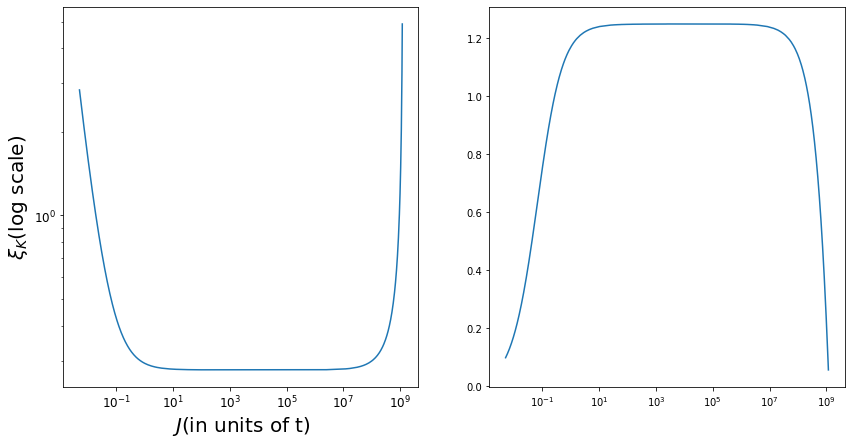

In [370]:
figure,ax=plt.subplots(1,2)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot(J0arr,1/(LambdaFParr/Lambda0),label='URG')
ax[0].tick_params(labelsize='large')
ax[0].set_xlabel(r'$J$(in units of t)',fontsize=20)
ax[0].set_ylabel(r'$\xi_{K}$(log scale)',fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale
ax[1].plot(J0arr,JfixedArr,label='URG')

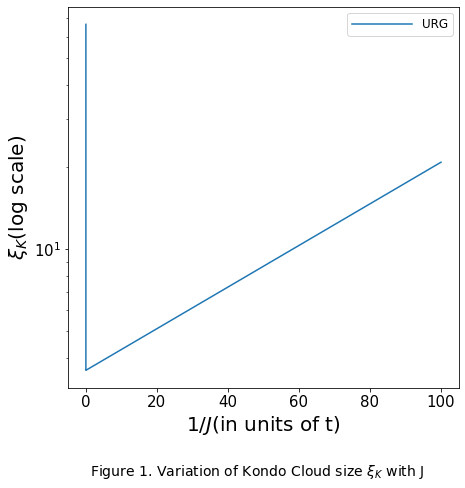

In [14]:
figure,ax=plt.subplots(1)
ax.set_yscale('log')
ax.plot(1/J0arr,1/(LambdaFParr*Lambda0),label='URG')
#ax.plot(1/J0arr, 1/((Lambda1_looparr*Lambda0)),label='1-loop')
#ax.plot(1/J0arr, 1/(np.exp(-1/J0arr)*Lambda0),label='1-loop')
ax.tick_params(labelsize=15)
ax.set_xlabel(r'$1/J$(in units of t)',fontsize=20)
ax.set_ylabel(r'$\xi_{K}$(log scale)',fontsize=20)
ax.legend(handlelength=5,fontsize=12)
txt=r"Figure 1. Variation of Kondo Cloud size $\xi_{K}$ with J"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.savefig('KondoCloudURG.png')

In [286]:
J0=-4/1000
J1=np.zeros(steps)
J1[0]=J0
for i in range(len(lambdaF)-1):
    Ek=lambdaF[i]*np.sqrt(0.2)-E_F
    if((J1[i]<0) & (((omega-Ek)**2-J1[i]**2/16)>0)):
        ren=2*np.pi*np.sqrt(0.2)*J1[i]*(1/((omega-Ek)**2-J1[i]**2/16))*J1[i]*(omega-Ek)
        J1[i+1]=J1[i]+ren
        k=i
    else:
        J1[i:]=J1[k]
        break

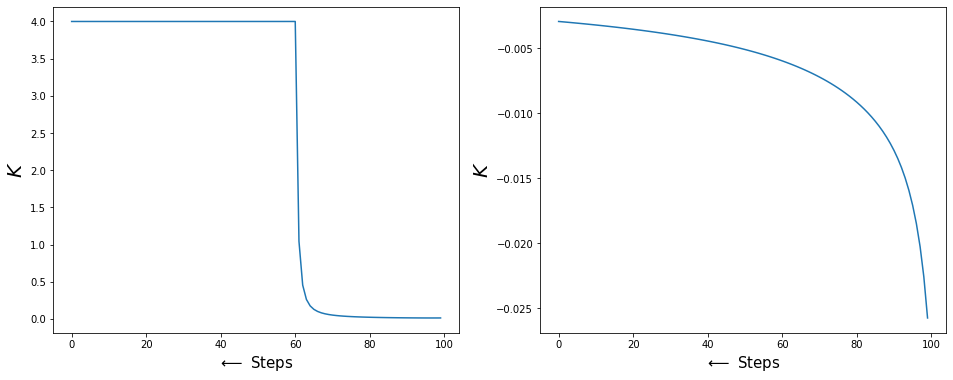

In [13]:
figure,ax=plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [16,6]
ax[0].plot(np.log(Lambda/Lambda0)/np.log(0.8),J[::-1]/(omega-Lambda[::-1]*np.sqrt(0.2)+E_F))
ax[1].plot(np.log(Lambda/Lambda0)/np.log(0.8),J1[::-1]/(omega-Lambda[::-1]*np.sqrt(0.2)+E_F))
ax[0].set_ylabel(r"$K$",fontsize=20)
ax[0].set_xlabel(r'$\longleftarrow$ Steps',fontsize=15)
ax[1].set_ylabel(r"$K$",fontsize=20)
ax[1].set_xlabel(r'$\longleftarrow$ Steps',fontsize=15)
plt.savefig("RG_Flow.svg")